In [1]:
import numpy as np
from scipy.integrate import quad, dblquad
import trimesh as tm

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt

## Problem description

The goal is to solve the Heat equation with no flux boundary condition in 3D on the unit cube domain using the finite element method.<br>
The strong form of the heat equation is given by:

$ \frac{\partial u}{\partial t} = c \Delta u$ on $\Omega$ <br>
where $\Omega$ is the domain of interest anc c is a diffusion coefficient constant across space and time. <br>

The Neuman boundary conditions are given by: <br>
$\nabla u \cdot \hat{n} = 0$ on $\Gamma$ <br>
where $\Gamma$ is the boundary of the domain and were $n$ is the outward normal vector to the boundary. <br>

We will solve this equation using the Garlekin method of weighted residuals. The weak form of the Heat equation is given by:

$ \int_{\Omega}  \frac{\partial u}{\partial t} \, \phi_j \;  d\Omega -   c\int_{\Omega} \Delta u \phi_j \; d\Omega = 0$ where $\phi_j$ is a test function.

After applying Green's first identity, we obtain:

$\int_{\Omega}  \frac{\partial u}{\partial t} \, \phi_j \;  d\Omega  + c \int_{\Omega} \nabla u \cdot \nabla \phi_j \; d\Omega  = \int_{\Gamma} \phi_j \nabla u \cdot n \;  d\Gamma$

Now we expand $u(t, x, y)$ in terms of a finite element basis functions $u(t, x, y) = \sum_{i} \alpha_i(t) \cdot \phi_i(x,y)$:

$\sum_{i} \frac{d \alpha_i}{d t} \, \int_{\Omega}   \phi_i \phi_j \;  d\Omega  + c \sum_{i} \alpha_i \int_{\Omega} \nabla  \phi_i \cdot \nabla \phi_j \; d\Omega  = \int_{\Gamma} \phi_j \nabla u \cdot n \;  d\Gamma$

We can write this in matrix form as:
$M \frac{d \vec{\alpha}}{d t} + c K \vec{\alpha} = c \vec{b} $

We solve this system of equations over time with the backward Euler method (Implicit time integrator):

$M \frac{\vec{\alpha}^{n+1} -  \vec{\alpha}^{n} }{h} + c K \vec{\alpha}^{n+1} = c \vec{b} $ where h is the time step.

$M \vec{\alpha}^{n+1} + c h K \vec{\alpha}^{n+1} = M \vec{\alpha}^{n} + c h \vec{b} $

$\left[ M + c h K \right] \vec{\alpha}^{n+1} = M \vec{\alpha}^{n} + c h \vec{b} $

Since we have homogeneous Neuman boundary conditions, the boundary term on the right hand side of the weak form is zero.

$\left[ M + c h K \right] \vec{\alpha}^{n+1} = M \vec{\alpha}^{n}$





To interpolate $u$ in our triangular elements, we will use a first order Lagrange basis function. 
The basis functions in the element are given by:

$\phi_1(u,v) = u$

$\phi_2(u,v) = v$

$\phi_3(u,v) = 1-u-v$

Where $u$, $v$, and $w=1-u-v$ are the barycentric coordinates of a point in the element.

In [2]:
def basis_fn_1(u, v): return u
def basis_fn_2(u, v): return v
def basis_fn_3(u, v): return 1 - u - v

grad_basis_fn_1 = np.array([1, 0])
grad_basis_fn_2 = np.array([0, 1])
grad_basis_fn_3 = np.array([-1, -1])

basis_fn_lst = [basis_fn_1, basis_fn_2, basis_fn_3]
grad_basis_fn_lst = [grad_basis_fn_1, grad_basis_fn_2, grad_basis_fn_3]
n_local_basis_fn = len(basis_fn_lst)

In [3]:
#Load the square triangulated mesh
mesh = tm.load_mesh('unstructured_square.obj')

#Make sure that the origin of the mesh is 0,0
mesh.vertices -= mesh.vertices.min(axis=0)

#Remove the z coordinate
mesh.vertices = mesh.vertices[:, :2]

#Get the edges located at the boundary of the mesh
mesh.boundary_edges = mesh.edges[tm.grouping.group_rows(mesh.edges_sorted, require_count=1)]

#Get the vertices located at the boundary of the mesh
mesh.boundary_vertices_idx = np.unique(mesh.boundary_edges)

#Create a unique idx for each edge and relate it to the position of the edge in the mesh.edges_unique array.
mesh.unique_idx_to_edge_idx = {
    tuple(sorted(v)): i for i, v in enumerate(mesh.edges_unique)
}

n_vertices = len(mesh.vertices)
n_faces = len(mesh.faces)
n_edges = len(mesh.edges_unique)
n_boundary_vertices = len(mesh.boundary_vertices_idx)

# For each edge we want to know the two faces that share the edge
edge_face_ar = np.zeros((n_edges, 2), dtype=np.int32)
edge_face_ar.fill(-1)

for face_id, face in enumerate(mesh.faces):

    e1_idx = mesh.unique_idx_to_edge_idx[tuple(sorted(face[[0, 1]]))]
    e2_idx = mesh.unique_idx_to_edge_idx[tuple(sorted(face[[1, 2]]))]
    e3_idx = mesh.unique_idx_to_edge_idx[tuple(sorted(face[[2, 0]]))]


    if edge_face_ar[e1_idx, 0] == -1:
        edge_face_ar[e1_idx, 0] = face_id
    else:
        edge_face_ar[e1_idx, 1] = face_id

    if edge_face_ar[e2_idx, 0] == -1:
        edge_face_ar[e2_idx, 0] = face_id
    else:
        edge_face_ar[e2_idx, 1] = face_id

    if edge_face_ar[e3_idx, 0] == -1:
        edge_face_ar[e3_idx, 0] = face_id
    else:
        edge_face_ar[e3_idx, 1] = face_id

In [4]:
#Integrate the product of the basis functions over the reference triangle

#This is the mass matrix for the reference triangle
M_reference = np.zeros((n_local_basis_fn, n_local_basis_fn))

for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
        M_reference[i, j] = dblquad(lambda u, v: basis_fn_lst[i](u, v) * basis_fn_lst[j](u, v), 0, 1, lambda u: 0, lambda u: 1-u)[0]
        M_reference[j, i] = M_reference[i, j] 


In [5]:
# For each triangle in the mesh we need to compute the Jacobian of the map from global to local coordinates
p1_ar = mesh.vertices[mesh.faces[:, 0]]
p2_ar = mesh.vertices[mesh.faces[:, 1]]
p3_ar = mesh.vertices[mesh.faces[:, 2]] 

p3_to_p1_ar = p1_ar - p3_ar
p3_to_p2_ar = p2_ar - p3_ar

jacobian_ar = np.zeros((n_faces, 2, 2))
jacobian_ar[:, 0, 0] = p3_to_p1_ar[:, 0]
jacobian_ar[:, 0, 1] = p3_to_p1_ar[:, 1]
jacobian_ar[:, 1, 0] = p3_to_p2_ar[:, 0]
jacobian_ar[:, 1, 1] = p3_to_p2_ar[:, 1] 

#Compute the determinant of the Jacobian
det_jacobian_ar = jacobian_ar[:, 0, 0] * jacobian_ar[:, 1, 1] - jacobian_ar[:, 0, 1] * jacobian_ar[:, 1, 0]

#Compute the inverse of the Jacobian
inv_jacobian_ar = np.zeros((n_faces, 2, 2))
inv_jacobian_ar[:, 0, 0] =  jacobian_ar[:, 1, 1]
inv_jacobian_ar[:, 0, 1] = -jacobian_ar[:, 0, 1]
inv_jacobian_ar[:, 1, 0] = -jacobian_ar[:, 1, 0]
inv_jacobian_ar[:, 1, 1] =  jacobian_ar[:, 0, 0]
inv_jacobian_ar /= det_jacobian_ar[:, np.newaxis, np.newaxis]

#This list stores the product of the gradient of the basis functions with the inverse of the Jacobian
grad_basis_fn_inv_jacobian_lst = [np.dot(inv_jacobian_ar, grad_basis_fn_lst[i]) for i in range(n_local_basis_fn)]


#Now we compute the local mass matrix for each triangle
local_stiffness_matrix_ar   = np.zeros((n_faces, n_local_basis_fn, n_local_basis_fn))
local_mass_matrix_ar        = np.zeros((n_faces, n_local_basis_fn, n_local_basis_fn))

#Compute the local stiffness and mass matrices
for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
 
        #Stiffness matrix
        local_stiffness_matrix_ar[:, i, j] = 0.5 * det_jacobian_ar * np.sum(grad_basis_fn_inv_jacobian_lst[i] * grad_basis_fn_inv_jacobian_lst[j], axis = 1)
        local_stiffness_matrix_ar[:, j, i] = local_stiffness_matrix_ar[:, i, j]

        #Mass matrix
        local_mass_matrix_ar[:, i, j] =  det_jacobian_ar * M_reference[i, j]
        local_mass_matrix_ar[:, j, i] =  local_mass_matrix_ar[:, i, j]



#Now we need to assemble the global stiffness matrix
row_id = np.repeat(mesh.faces, n_local_basis_fn).flatten()
col_id = np.tile(mesh.faces, n_local_basis_fn).flatten()

stiffness_data   = local_stiffness_matrix_ar.flatten()
mass_data = local_mass_matrix_ar.flatten()

# Create the sparse global stiffness matrix
global_stiffness_matrix = csc_matrix((stiffness_data.flatten(), (row_id, col_id)), shape=(n_vertices, n_vertices))
global_mass_matrix =      csc_matrix((mass_data.flatten(), (row_id, col_id)), shape=(n_vertices, n_vertices))

global_stiffness_matrix.sum_duplicates()
global_mass_matrix.sum_duplicates()

In [6]:
#Compute the update matrix
time_step = 0.01
diffusion_coefficient = 1.0
update_matrix = global_mass_matrix + time_step * diffusion_coefficient * global_stiffness_matrix

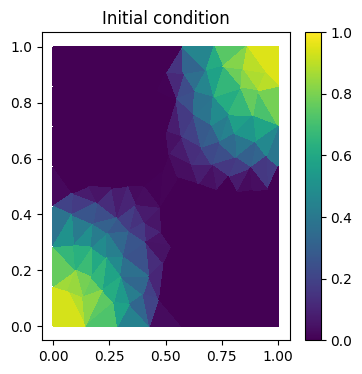

In [7]:
# Compute the coefficient of the initial condition. The points located at the center of the circle with radius 0.1 and origin (0.5, 0.5) are set to 1
center = np.array([0.5, 0.5])
radius = 0.15

initial_condition = np.cos(np.pi * mesh.vertices[:, 0]) * np.cos(np.pi * mesh.vertices[:, 1])

#Plot the initial condition
plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, initial_condition, shading='flat', vmin=0, vmax=1.0)
plt.colorbar()
plt.title('Initial condition')
plt.show()

[]

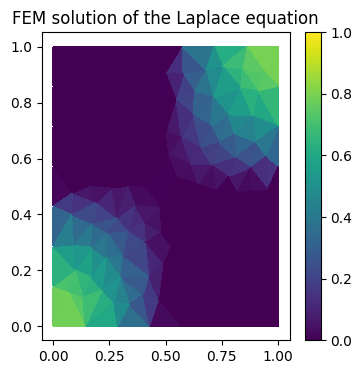

In [8]:
#Advance the system by one time step
sol = spsolve(update_matrix, global_mass_matrix.dot(initial_condition))


#Plot the solution
plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, sol, shading='flat', vmin=0, vmax=1.0)
plt.colorbar()
plt.title('FEM solution of the Laplace equation')
plt.plot()


[]

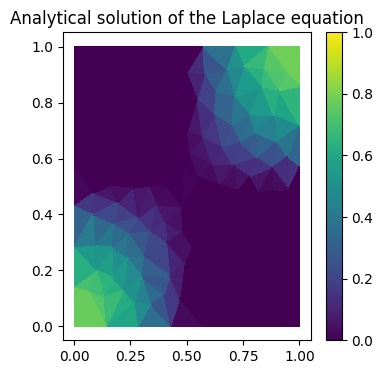

In [9]:
analytical_solution  = np.cos(np.pi * mesh.vertices[:, 0]) * np.cos(np.pi * mesh.vertices[:, 1]) * np.exp(-2 * np.pi**2 * diffusion_coefficient * time_step)

plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, analytical_solution.flatten(), shading='flat', vmin=0, vmax=1.0)
plt.colorbar()
plt.title('Analytical solution of the Laplace equation')
plt.plot()

Text(0.5, 1.0, 'Absolute error')

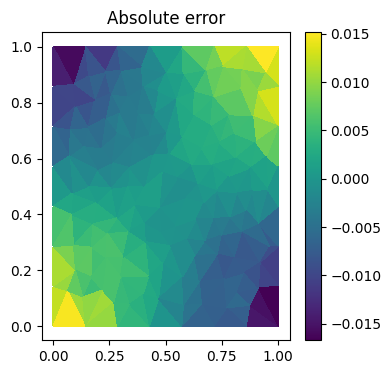

In [10]:
absolute_error = sol - analytical_solution

plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, absolute_error, shading='flat')
plt.colorbar()
plt.title('Absolute error')

Text(0.5, 1.0, 'Relative error (%)')

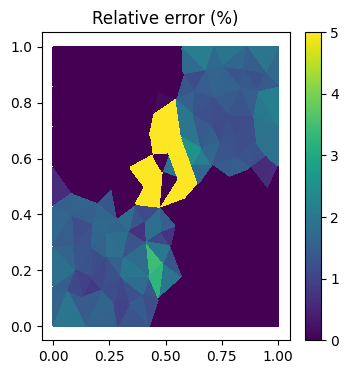

In [11]:
#Relative error

relative_error = np.abs(sol - analytical_solution) *100.0 / analytical_solution

plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, relative_error, shading='flat', vmax=5, vmin=0)
plt.colorbar()
plt.title('Relative error (%)')

